In [2]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.data import Dataset
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import random

2024-08-07 04:28:16.979705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 04:28:17.114168: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-08-07 04:28:17.114851: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-08-07 04:28:17.115074: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-0

In [3]:
# Load the pre-trained model
model_path = 'models/EfficientNetV2S_best_model_2'
model = tf.keras.models.load_model(model_path)

2024-08-07 04:28:31.610087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-07 04:28:31.620654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-07 04:28:31.622348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-07 04:28:31.624386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

In [4]:
# Define the path to the new dataset
dataset_path = 'local_image_directory/test'

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize images
    batch_size=32,  # Set batch size
    shuffle=True  # Shuffle the dataset
)

Found 1098 files belonging to 3 classes.


In [5]:
# Evaluate the model on the new dataset
loss, accuracy = model.evaluate(dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2024-08-07 04:29:20.550909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


35/35 [==============================] - 20s 230ms/step - loss: 0.5429 - accuracy: 0.7905
Loss: 0.5429201722145081
Accuracy: 0.7905282378196716


In [6]:
# Inspect the model layers to find the last convolutional layer
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f'The last convolutional layer is: {last_conv_layer_name}')

The last convolutional layer is: top_conv


In [7]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [15]:
# Get a list of all files in the source directory
all_glide_files = [f for f in os.listdir('local_image_directory/test/glide') if os.path.isfile(os.path.join('local_image_directory/test/glide', f))]
all_slab_files = [f for f in os.listdir('local_image_directory/test/slab') if os.path.isfile(os.path.join('local_image_directory/test/slab', f))]
all_loose_files = [f for f in os.listdir('local_image_directory/test/loose') if os.path.isfile(os.path.join('local_image_directory/test/loose', f))]

# Number of images required
CAM_img_count = 5

# Shuffle the file list for random distribution
random.shuffle(all_glide_files)
random.shuffle(all_slab_files)
random.shuffle(all_loose_files)

# Split the files
CAM_glide_files = all_glide_files[:CAM_img_count]
CAM_slab_files = all_slab_files[:CAM_img_count]
CAM_loose_files = all_loose_files[:CAM_img_count]

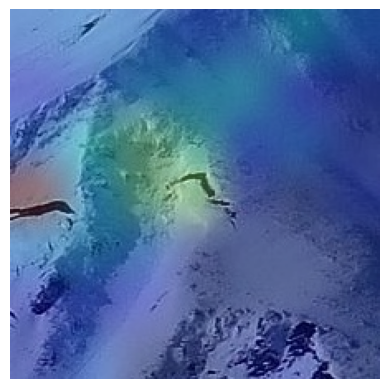

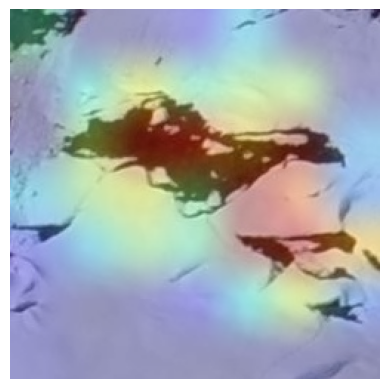

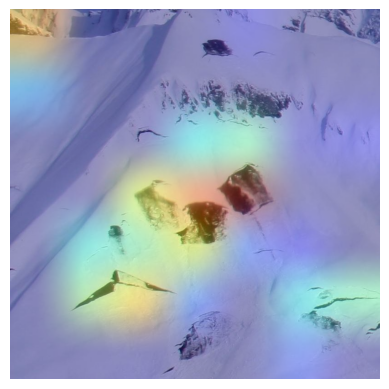

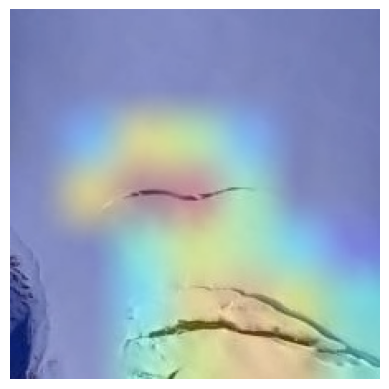

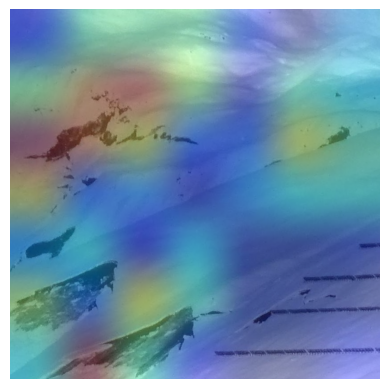

In [16]:
for img_name in CAM_glide_files:
    img_path = os.path.join('local_image_directory/test/glide', img_name)

    # Load the image and preprocess
    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)

    # Generate grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)

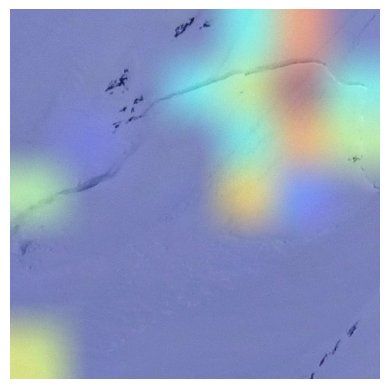

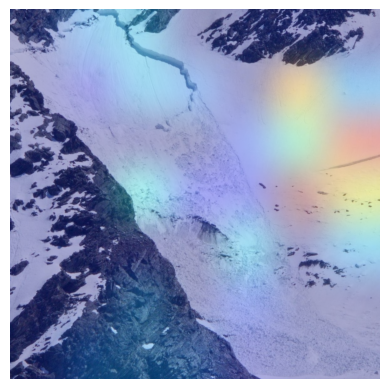

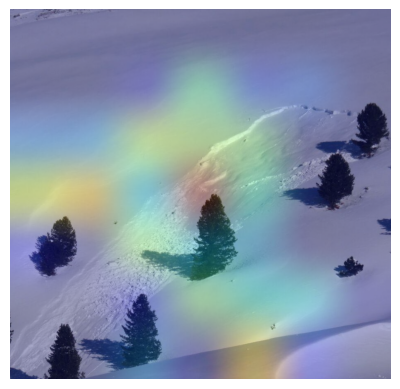

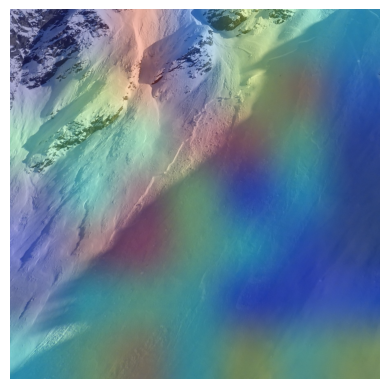

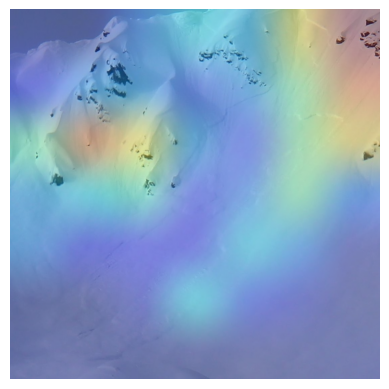

In [17]:
for img_name in CAM_slab_files:
    img_path = os.path.join('local_image_directory/test/slab', img_name)

    # Load the image and preprocess
    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)

    # Generate grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)

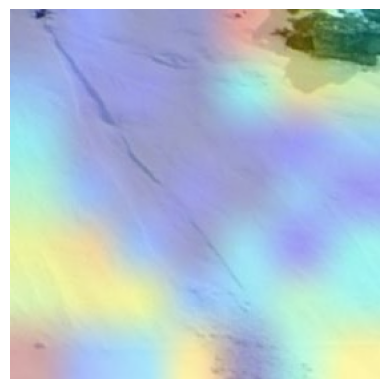

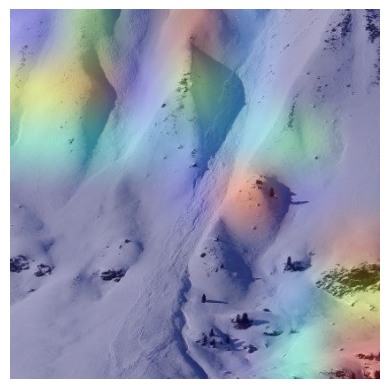

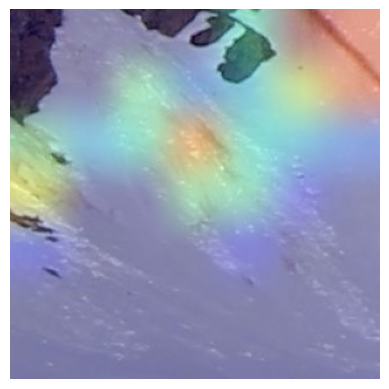

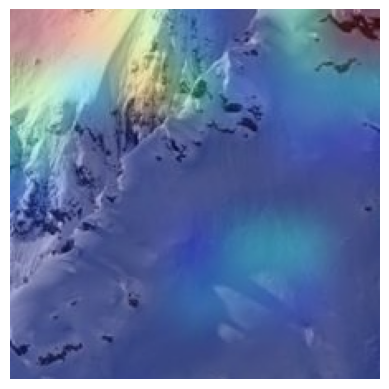

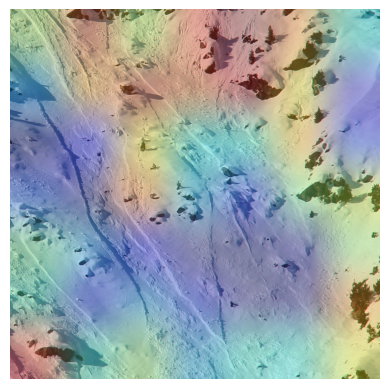

In [18]:
for img_name in CAM_loose_files:
    img_path = os.path.join('local_image_directory/test/loose', img_name)

    # Load the image and preprocess
    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)

    # Generate grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)

## Wide angle

In [19]:
# Get a list of all files in the source directory
all_glide_files = [f for f in os.listdir('local_image_directory_2/glide') if os.path.isfile(os.path.join('local_image_directory_2/glide', f))]
all_slab_files = [f for f in os.listdir('local_image_directory_2/slab') if os.path.isfile(os.path.join('local_image_directory_2/slab', f))]
all_loose_files = [f for f in os.listdir('local_image_directory_2/loose') if os.path.isfile(os.path.join('local_image_directory_2/loose', f))]

# Number of images required
CAM_img_count = 5

# Shuffle the file list for random distribution
random.shuffle(all_glide_files)
random.shuffle(all_slab_files)
random.shuffle(all_loose_files)

# Split the files
CAM_glide_files = all_glide_files[:CAM_img_count]
CAM_slab_files = all_slab_files[:CAM_img_count]
CAM_loose_files = all_loose_files[:CAM_img_count]

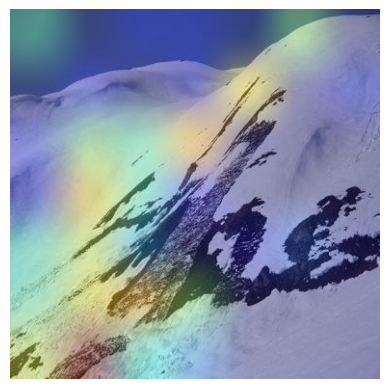

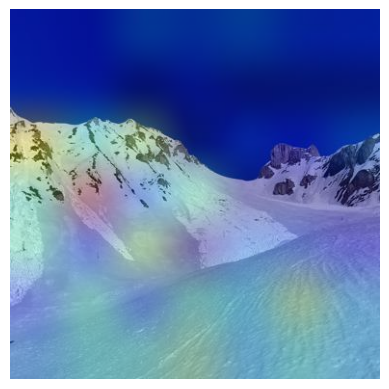

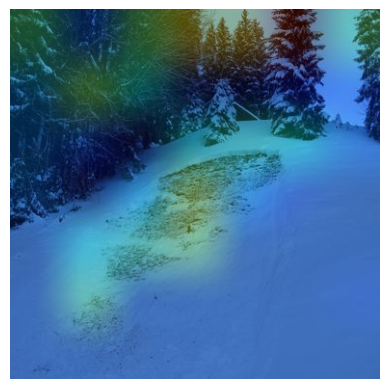

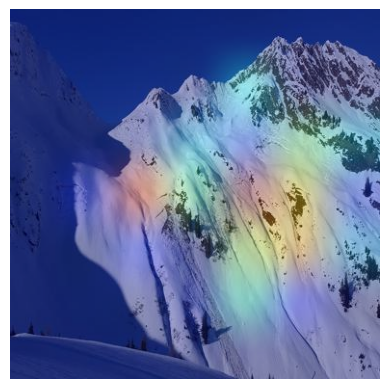

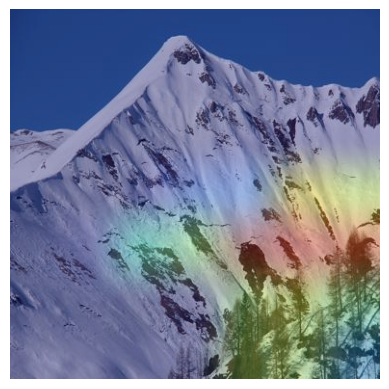

In [20]:
for img_name in CAM_glide_files:
    img_path = os.path.join('local_image_directory_2/glide', img_name)

    # Load the image and preprocess
    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)

    # Generate grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)

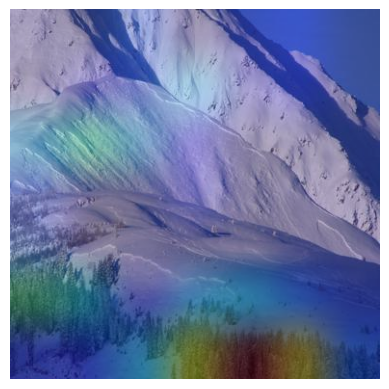

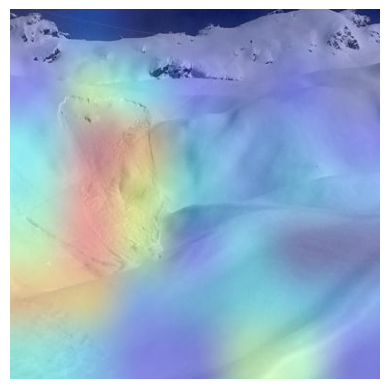

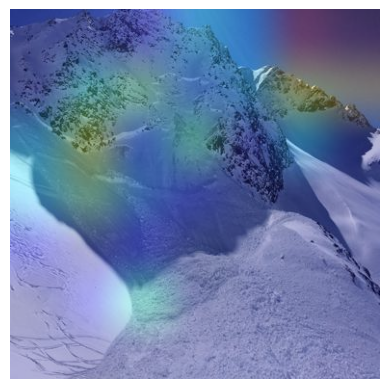

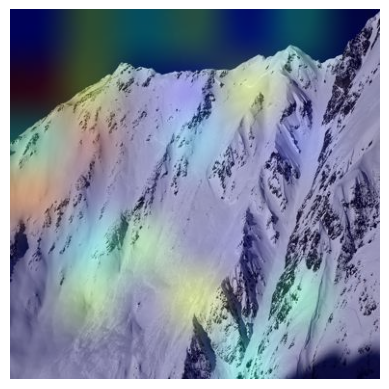

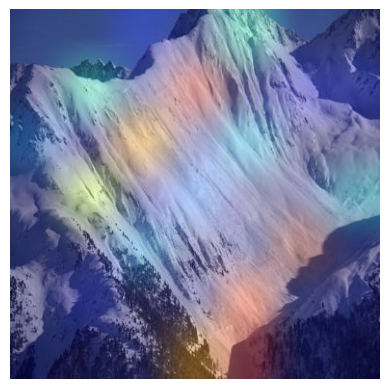

In [21]:
for img_name in CAM_slab_files:
    img_path = os.path.join('local_image_directory_2/slab', img_name)

    # Load the image and preprocess
    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)

    # Generate grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)

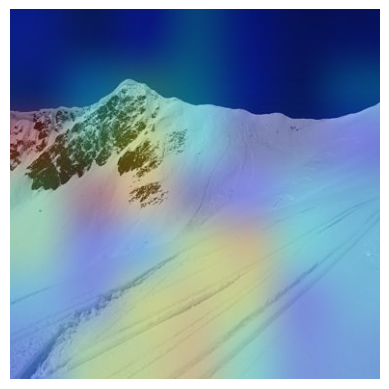

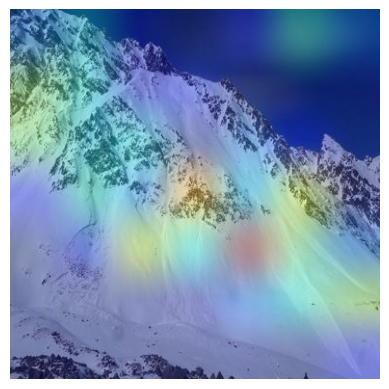

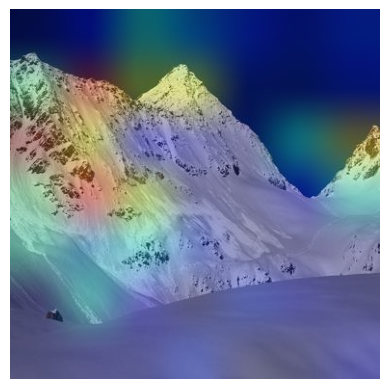

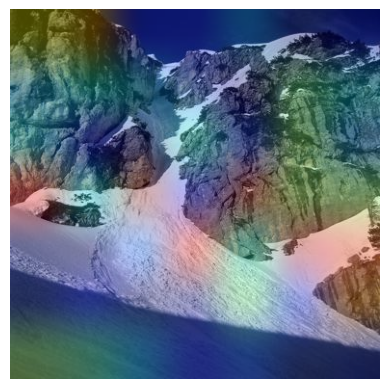

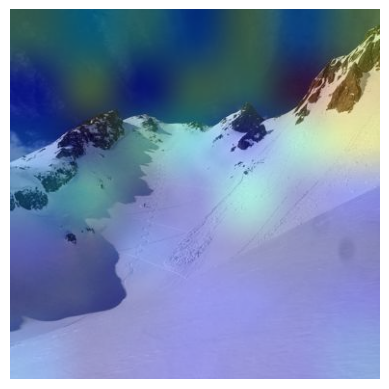

In [22]:
for img_name in CAM_loose_files:
    img_path = os.path.join('local_image_directory_2/loose', img_name)

    # Load the image and preprocess
    img_size = (224, 224)
    img_array = get_img_array(img_path, img_size)

    # Generate grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)